# Проект: HR-аналитика

## Описание исследования

Это проект, в котором необходимо применить навыки анализа данных и машинного обучения для решения задач HR-аналитики. Работа включает предсказание уровня удовлетворённости сотрудников и их вероятности увольнения на основе различных характеристик. Эти предсказания помогут компании «Работа с заботой» оптимизировать управление персоналом, минимизировать отток сотрудников и улучшить бизнес-показатели.

## Цель исследования

Разработать модели для предсказания:

1. Уровня удовлетворённости сотрудников работой.
2. Вероятности увольнения сотрудников.

## Суть исследования

Задачи направлены на построение предсказательных моделей, которые помогут компании оценивать текущие процессы и принимать меры для снижения текучести кадров. Исследуются характеристики сотрудников, такие как уровень должности, загруженность, зарплата и другие факторы, влияющие на удовлетворённость и увольнение.

## Задачи исследования

1. Изучить данные о сотрудниках.
2. Провести исследовательский анализ данных для выявления зависимостей.
3. Подготовить данные для моделирования.
4. Построить и обучить модели для решения двух задач:
    - Предсказание уровня удовлетворённости сотрудников.
    - Предсказание вероятности увольнения сотрудников.
5. Оценить качество моделей с использованием метрик SMAPE и ROC-AUC.

## Исходные данные

Для выполнения проекта предоставлены следующие файлы:

- **train_job_satisfaction_rate.csv** — тренировочные данные для предсказания уровня удовлетворённости.
- **test_features.csv** — признаки для тестовой выборки по первой задаче.
- **test_target_job_satisfaction_rate.csv** — целевые значения для тестовой выборки по первой задаче.
- **train_quit.csv** — тренировочные данные для предсказания увольнений.
- **test_target_quit.csv** — целевые значения для тестовой выборки по второй задаче.

## Структура исследования

Исследование состоит из нескольких шагов:

### Часть 1. Изучение общей информации
1. Загрузка и исследование файлов с данными.
2. Обработка пропусков и ошибок.

### Часть 2. Подготовка данных
1. Приведение данных к корректным типам.
2. Устранение аномалий.

### Часть 3. Исследовательский анализ данных
1. Анализ всех признаков для выявления влияния на целевые переменные.
2. Построение портретов сотрудников с разным уровнем удовлетворённости и вероятностью увольнения.

### Часть 4. Моделирование
1. Обучение моделей для предсказания уровня удовлетворённости и увольнения сотрудников.
2. Оценка моделей по метрикам SMAPE и ROC-AUC.

### Часть 5. Выводы
1. Сравнение моделей и формулировка рекомендаций для бизнеса.

---

Этот проект позволит лучше понять ключевые факторы, влияющие на удовлетворённость сотрудников и их увольнение, что поможет компании эффективно управлять персоналом.


In [1]:
pip install -q --upgrade scikit-learn matplotlib numpy seaborn shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score, r2_score, mean_absolute_error

from phik.report import plot_correlation_matrix

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

from scipy.stats import mannwhitneyu

## Задача 1: предсказание уровня удовлетворённости сотрудника

###  Загрузка данных

In [4]:
satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
datasets = [satisfaction, test_features, test_target_job]

In [9]:
for i in datasets:
    print(i.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 -------------

В данных есть пропуски, типы данных в порядке

### Шаг 2. Предобработка данных

Проверим пропуски

In [10]:
satisfaction[satisfaction.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [11]:
test_features[test_features.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Пропусков не так много, заполним их в пайплайне подготовки данных

Проверим дубликаты

In [12]:
for i in datasets:
    print(i.duplicated().sum(), '\n')

0 

0 

0 



In [13]:
for i in datasets:
    for j in i.select_dtypes('object'):
        print(i[j].unique(), '\n')

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

['junior' 'middle' 'sinior' nan] 

['medium' 'high' 'low'] 

['no' 'yes'] 

['no' 'yes'] 

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

['junior' 'middle' 'sinior' nan] 

['medium' 'low' 'high' ' '] 

['no' 'yes'] 

['no' 'yes'] 



Исправим ошибку

In [14]:
satisfaction.loc[satisfaction['level'] == 'sinior', 'level'] = 'senior'
test_features.loc[test_features['level'] == 'sinior', 'level'] = 'senior'

В тестовой выборке есть строки со значением ' '

In [15]:
test_features.query('dept == " " or workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Учтем это и заполним в пайплайне

Была исправлена ошибка в категориальной переменной, ошибочные значения ' ' заменены на те, которые встречаются чаще всего. Пропуски будут заполнены при подготовке данных

### Исследовательский анализ данных

Построим графики для всех признаков

In [16]:
def num_hist(df, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df[i].plot(kind='hist', bins=15, ax=axes[0])
        axes[0].set_title(f'Гистограмма {df[i].name}')
        axes[0].set_xlabel(df[i].name)
        axes[0].set_ylabel('Частота')

        df[i].plot(kind='box', ax=axes[1])
        axes[1].set_title(f'Boxplot {df[i].name}')
        
        plt.tight_layout()
        plt.show()

In [17]:
def cat_bar(df, lst):
     for i in lst:
        plt.figure()
        df[i].value_counts().plot(kind='bar')
        plt.title(df[i].name)
        plt.xlabel(df[i].name)
        plt.ylabel('Частота')
        plt.show()

In [18]:
satisfaction_num = ['salary', 'job_satisfaction_rate']
satisfaction_cat = [i for i in satisfaction.columns if i not in satisfaction_num and i != 'id']
test_features_num = ['salary']
test_features_cat = [i for i in test_features.columns if i not in test_features_num and i != 'id']
test_target_job_num = ['job_satisfaction_rate']

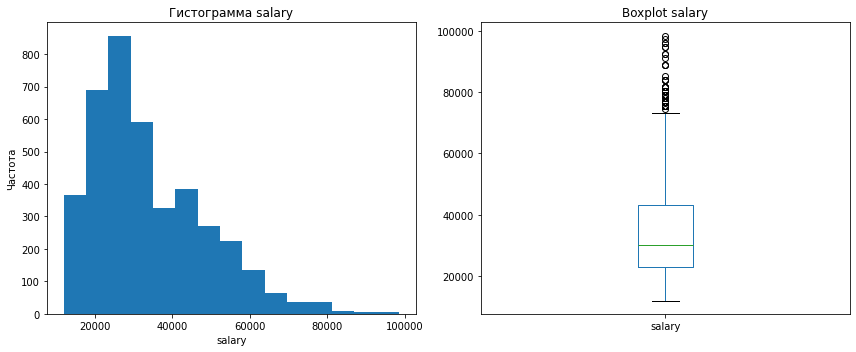

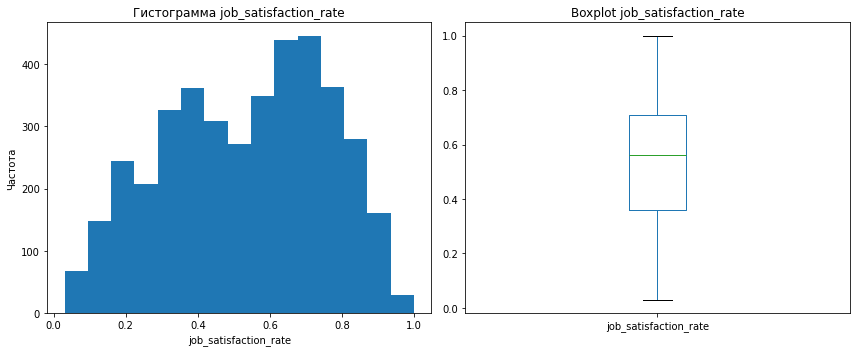

In [19]:
num_hist(satisfaction, satisfaction_num)

Ни один признак не распределен нормально, аномалий нет

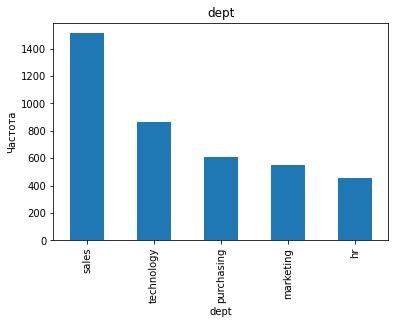

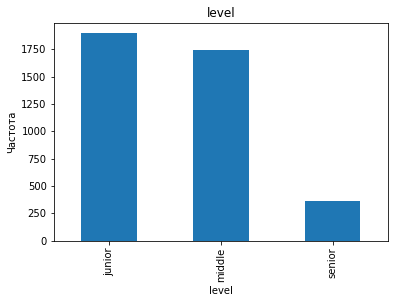

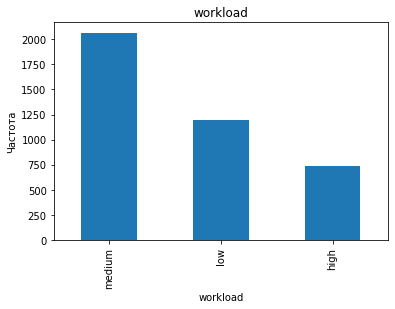

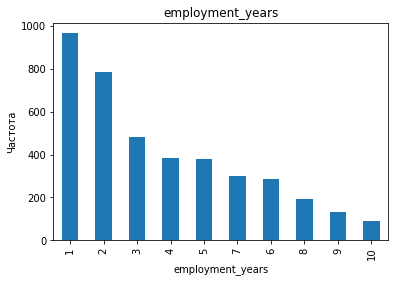

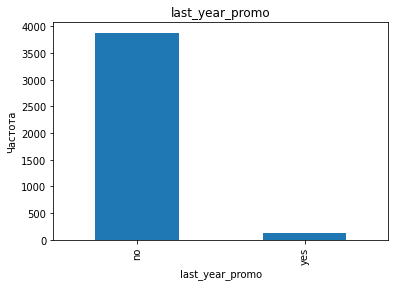

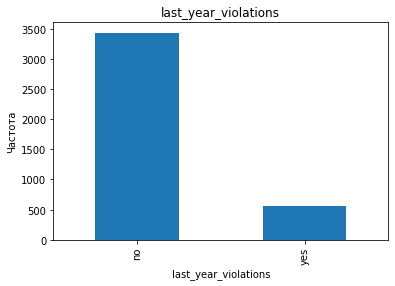

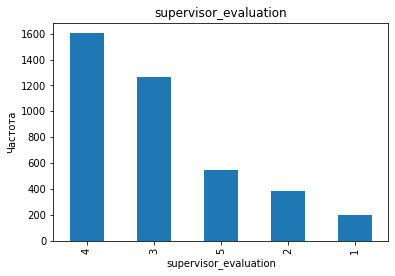

In [20]:
cat_bar(satisfaction, satisfaction_cat)

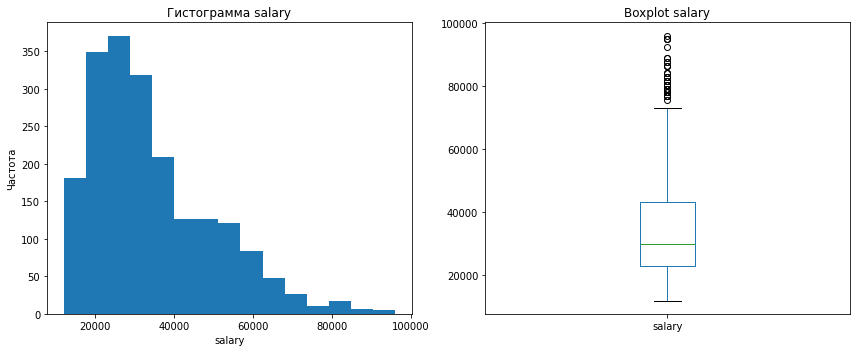

In [21]:
num_hist(test_features, test_features_num)

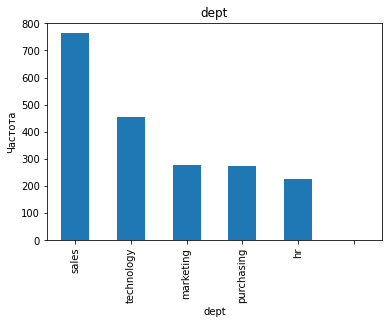

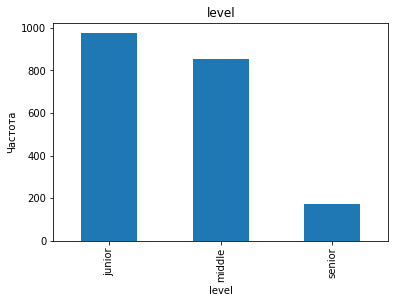

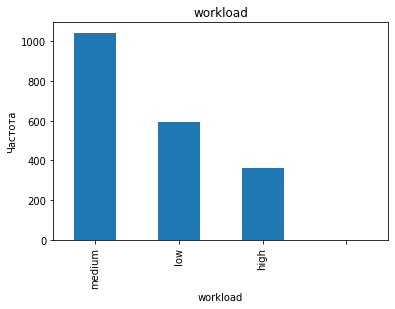

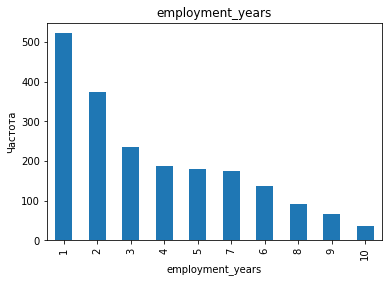

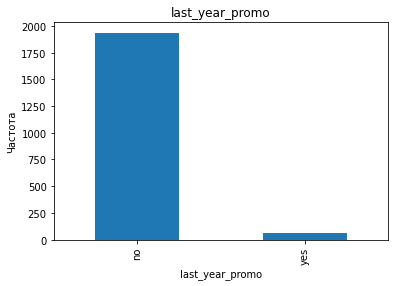

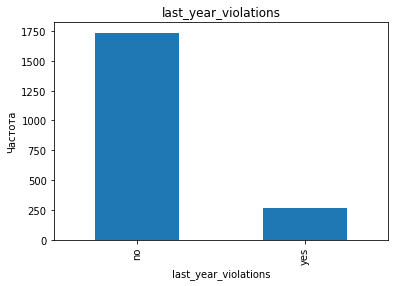

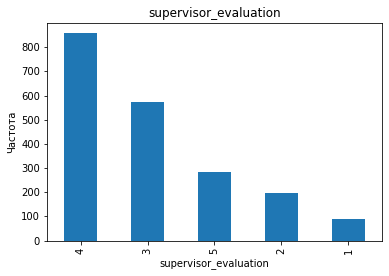

In [22]:
cat_bar(test_features, test_features_cat)

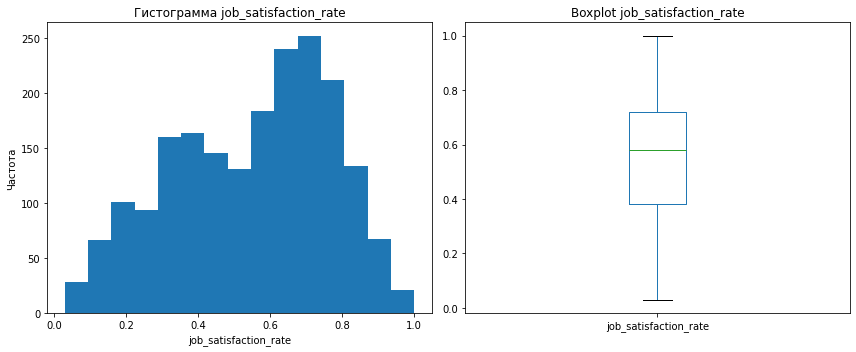

In [23]:
num_hist(test_target_job, test_target_job_num)

Проанализировав все графики, можно сделать обобщенный вывод по данным. Больше всего сотрудников в отделе продаж, со средним уровнем загруженности, имеющих должность junior и работающих в компании в пределах двух лет. Большая часть зарплат находится в диапазоне от 10 до 40 тысяч. В основном удовлетворенность работой - около 0.7, однако достаточно много случаев, когда она варьируется от 0.3 до 0.6 

Проблем в данных не обнаружено

Посмотрим кореляцию

In [24]:
cor = satisfaction.drop('id', axis=1).corr(method='spearman')

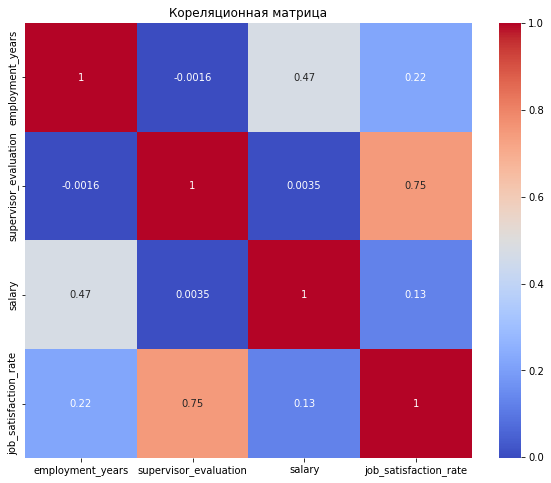

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, cmap='coolwarm');
plt.title('Кореляционная матрица')
plt.show()

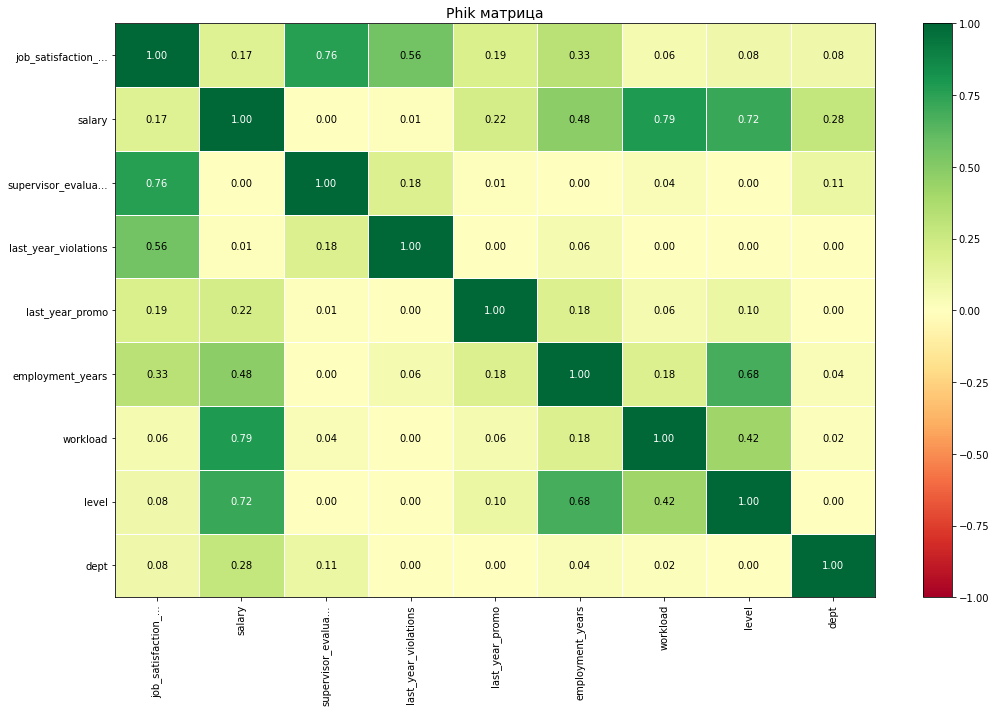

In [26]:
phik_matrix = satisfaction.drop('id', axis=1).\
phik_matrix(interval_cols=satisfaction.drop('id', axis=1).select_dtypes(exclude='object').columns)

plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=-1, vmax=1, title="Phik матрица", figsize=(15, 10))

plt.show()

Сильных зависимостей признаков и мультиколлинеарности нет

### Подготовка данных

Перед тем, как разделять данные на входные признаки и целевой, нужно проверить дубликаты при удалении признака id 

In [27]:
for i in [satisfaction.drop('id', axis=1), test_features.drop('id', axis=1)]:
    print(i.duplicated().sum(), '\n')

245 

557 



Удалим идентичные объекты из обучающей выборки

In [28]:
satisfaction_dropped_duplicates = satisfaction.drop('id', axis=1).drop_duplicates()

Теперь проверим, сходится ли порядок тестовых X и y </font>


In [29]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [30]:
test_target_job.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Порядок не соответствует, нужно его поменять

In [31]:
test_target_job = test_features[['id']].merge(test_target_job)

In [32]:
test_target_job.head()

,id,job_satisfaction_rate
0,485046,0.79
1,686555,0.72
2,467458,0.64
3,418655,0.60
4,789145,0.75


Создадим пайплайн, отвечающий за подготовку

In [33]:
X = satisfaction_dropped_duplicates.drop('job_satisfaction_rate', axis=1)
y = satisfaction_dropped_duplicates['job_satisfaction_rate']

In [34]:
X_test = test_features.drop(['id'], axis=1)

In [35]:
X.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [36]:
y_test = test_target_job['job_satisfaction_rate']

In [37]:
X.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [38]:
num_col = X.select_dtypes(exclude='object').columns
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']

In [39]:
for i in X_test.select_dtypes('object'):
    print(X[i].unique(), '\n')

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

['junior' 'middle' 'senior' nan] 

['medium' 'high' 'low'] 

['no' 'yes'] 

['no' 'yes'] 



In [40]:
ohe_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('imputer2', SimpleImputer(missing_values =' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

ord_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('imputer2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle' ,'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)

In [41]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [42]:
X_transformed = data_preprocessor.fit_transform(X)

In [43]:
X_test_transformed = data_preprocessor.transform(X_test)

### Обучение моделей

In [44]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [45]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [46]:
pipe = Pipeline([
    ('model', LinearRegression())
])


In [47]:
param_distributions = [
    {
        'model': [LinearRegression()],
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': range(1, 25),
        'model__min_samples_split': range(2, 10),
        'model__min_samples_leaf': range(1, 10)
    }
   
]

In [48]:
grid_search = GridSearchCV(
    pipe, 
    param_distributions, 
    cv=5, 
    scoring=smape_scorer, 
    n_jobs=-1, 
)

In [49]:
%%time
grid_search.fit(X_transformed, y)

CPU times: user 52.1 s, sys: 207 ms, total: 52.3 s
Wall time: 52.3 s


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [DecisionTreeRegressor(random_state=42)],
                          'model__max_depth': range(1, 25),
                          'model__min_samples_leaf': range(1, 10),
                          'model__min_samples_split': range(2, 10)}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [50]:
print(f'метрика SMAPE у лучшей модели - {grid_search.best_score_ * -1}')

метрика SMAPE у лучшей модели - 15.0384153272308


In [51]:
grid_search.best_params_

{'model': DecisionTreeRegressor(random_state=42),
 'model__max_depth': 20,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 8}

Параметры модели, лучше всего справляющейся с предсказаниями: Дерево решений, max_depth=18, min_samples_split=2, min_samples_leaf=3

### Оформление выводов

Возьмем модель с худшей метрикой smape и сравним значения важности признаков с деревом решений

In [52]:
y_pred = grid_search.predict(X_test_transformed)

In [53]:
result_df = pd.DataFrame(grid_search.cv_results_)

In [54]:
result_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002260,0.000353,0.000306,0.000035,LinearRegression(),NaN,NaN,NaN,{'model': LinearRegression()},-25.206527,-24.859881,-26.082386,-25.083587,-23.700211,-24.986518,0.765425,1657
1,0.001870,0.000131,0.000331,0.000017,DecisionTreeRegressor(random_state=42),1.0,1.0,2.0,{'model': DecisionTreeRegressor(random_state=4...,-26.413701,-25.155592,-26.215378,-26.064616,-24.953016,-25.760461,0.590595,1658
2,0.014305,0.024990,0.000411,0.000113,DecisionTreeRegressor(random_state=42),1.0,1.0,3.0,{'model': DecisionTreeRegressor(random_state=4...,-26.413701,-25.155592,-26.215378,-26.064616,-24.953016,-25.760461,0.590595,1658
3,0.002803,0.000197,0.000468,0.000067,DecisionTreeRegressor(random_state=42),1.0,1.0,4.0,{'model': DecisionTreeRegressor(random_state=4...,-26.413701,-25.155592,-26.215378,-26.064616,-24.953016,-25.760461,0.590595,1658
4,0.015598,0.026501,0.000435,0.000101,DecisionTreeRegressor(random_state=42),1.0,1.0,5.0,{'model': DecisionTreeRegressor(random_state=4...,-26.413701,-25.155592,-26.215378,-26.064616,-24.953016,-25.760461,0.590595,1658


In [55]:
linreg = LinearRegression()

In [56]:
tree = grid_search.best_estimator_.named_steps['model']

In [57]:
linreg.fit(X_transformed, y)
tree.fit(X_transformed, y)

DecisionTreeRegressor(max_depth=20, min_samples_split=8, random_state=42)

In [58]:
y_pred = linreg.predict(X_test_transformed)

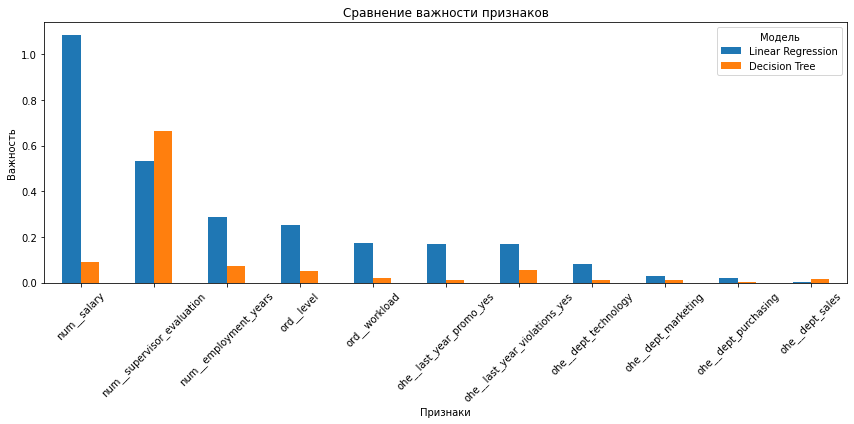

In [59]:
linear_importances = np.abs(linreg.coef_)
tree_importances = tree.feature_importances_

importance_df = pd.DataFrame({
    'Feature': data_preprocessor.get_feature_names_out(),
    'Linear Regression': linear_importances,
    'Decision Tree': tree_importances
})

importance_df = importance_df.set_index('Feature').sort_values(by='Linear Regression', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

importance_df[['Linear Regression', 'Decision Tree']].plot(kind='bar', ax=ax)
plt.title('Сравнение важности признаков')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45)
plt.legend(title='Модель')
plt.tight_layout()
plt.show()

В отличие от линейной регрессии, дерево решений предавало значительно меньший вес такому параметру, как зарплата. Это помогло минимизировать smape

## Задача 2: предсказание увольнения сотрудника из компании

 ### Загрузка данных

In [60]:
quit_train = pd.read_csv('/datasets/train_quit.csv')
test_target = pd.read_csv('/datasets/test_target_quit.csv')

In [61]:
quit_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [62]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [63]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [64]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропусков нет

### Предобработка данных

In [65]:
quit_train.duplicated().sum()

0

In [66]:
for i in quit_train.select_dtypes('object'):
    print(quit_train[i].unique()) 
    

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [67]:
quit_train.loc[quit_train['level'] == 'sinior', 'level'] = 'senior'

Дубликатов нет

### Исследовательский анализ

Построим графики распределения

In [68]:
quit_num = ['salary']
quit_cat = [i for i in quit_train.columns if i not in quit_num and i != 'id']

In [69]:
quit_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

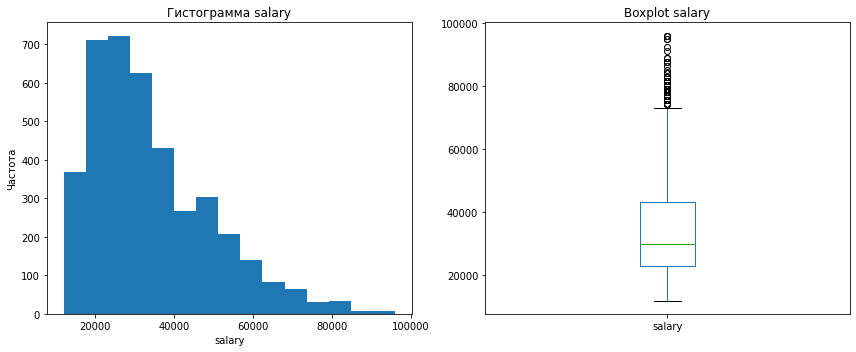

In [70]:
num_hist(quit_train,quit_num )

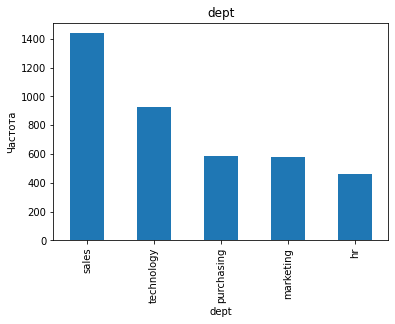

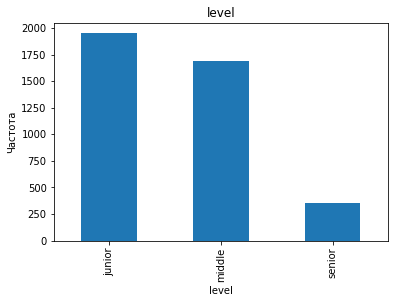

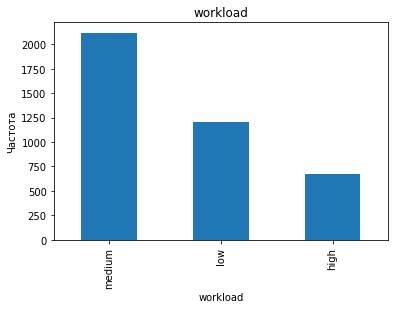

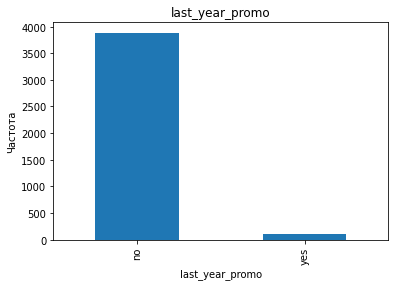

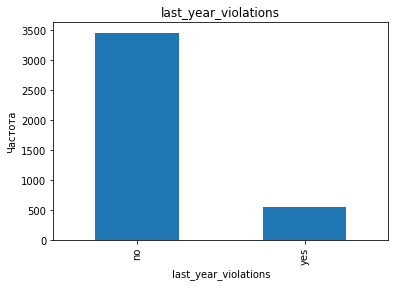

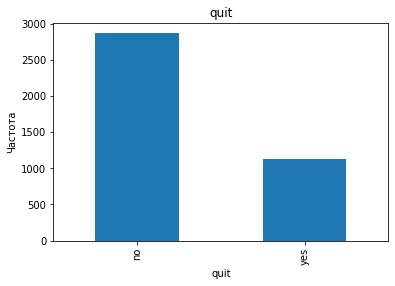

In [71]:
cat_bar(quit_train, quit_train.select_dtypes('object').columns)

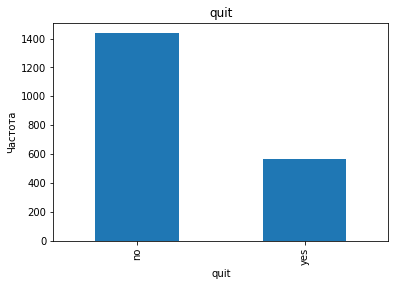

In [72]:
cat_bar(test_target, ['quit'])

Аномалий нет, в целевом признаке есть дисбаланс классов

За исключением нового признака quit, данные схожи с предыдущим набором. Сотрудников которые не уволились примерно в 2,5 раза больше тех, кто ушел

Стоит использовать roc_auc, которая имеет устойчивость к дисбалансу 

Составим портрет уволившегося сотрудника

In [73]:
quited = quit_train.query('quit == "yes"')

In [74]:
stayed = quit_train.query('quit == "no"')

In [75]:
def num_hist_group(df1, df2, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        sns.histplot(df1[i], bins=15, stat='density', common_norm=False, ax=axes[0], alpha=0.7)
        axes[0].set_title(f'Гистограмма {df1[i].name} группы')
        axes[0].set_xlabel(df1[i].name)
        axes[0].set_ylabel('Плотность')

        sns.histplot(df2[i], bins=15, stat='density', common_norm=False, ax=axes[1], alpha=0.7)
        axes[1].set_title(f'Гистограмма {df2[i].name}')
        axes[1].set_xlabel(df2[i].name)
        axes[1].set_ylabel('Плотность')
        
        plt.tight_layout()
        plt.show()

In [76]:
def cat_bar_group(df1, df2, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df1[i].value_counts().plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'{df1[i].name} группы')
        axes[0].set_xlabel(df1[i].name)
        axes[0].set_ylabel('Частота')

        df2[i].value_counts().plot(kind='bar', ax=axes[1])
        axes[1].set_title(f'общий {df2[i].name}')
        axes[1].set_xlabel(df2[i].name)
        axes[1].set_ylabel('Частота')
        
        plt.tight_layout()
        plt.show()


In [77]:
def cat_bar_group_norm(df1, df2, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df1[i].value_counts(normalize=True).plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'{df1[i].name} уволившихся')
        axes[0].set_xlabel(df1[i].name)
        axes[0].set_ylabel('Частота')

        df2[i].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
        axes[1].set_title(f'{df2[i].name} оставшихся')
        axes[1].set_xlabel(df2[i].name)
        axes[1].set_ylabel('Частота')
        
        plt.tight_layout()
        plt.show()


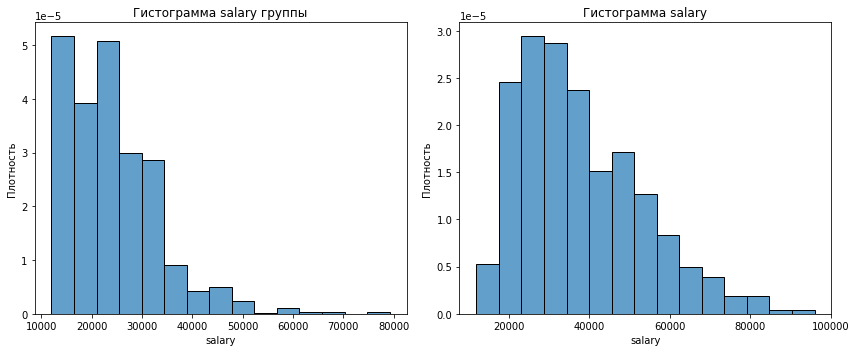

In [78]:
num_hist_group(quited, stayed, quit_num)

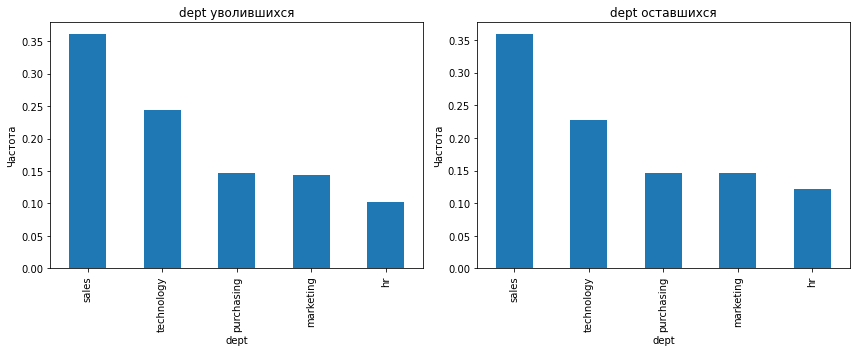

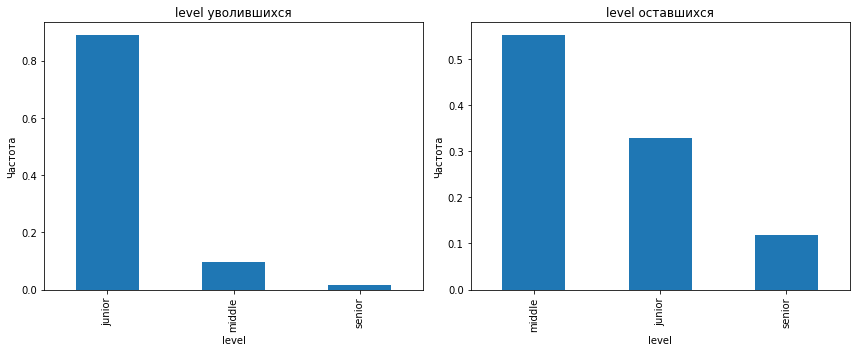

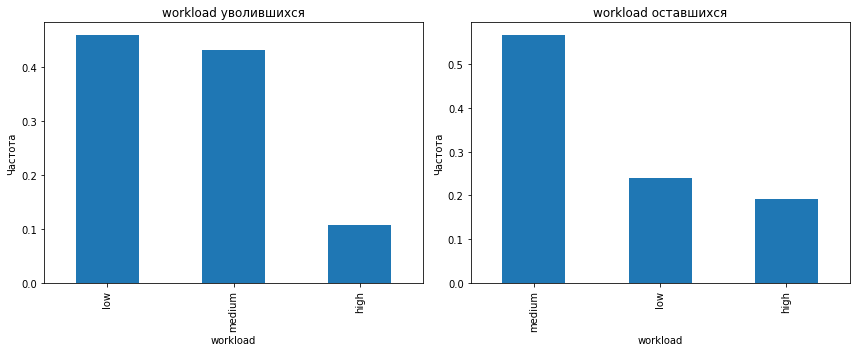

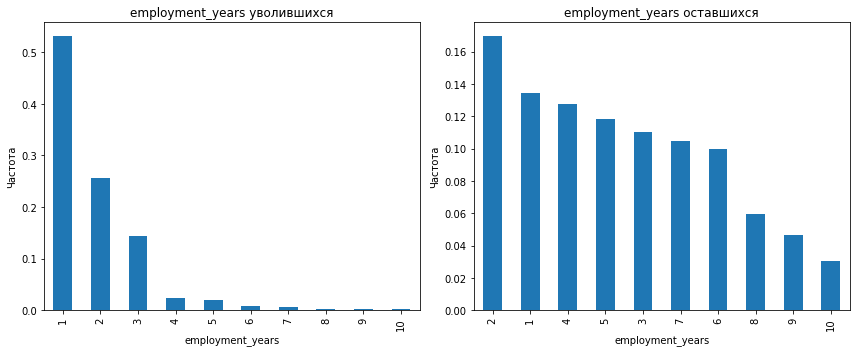

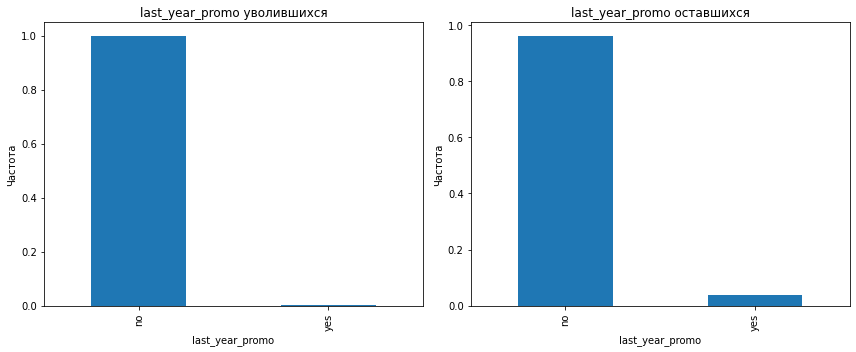

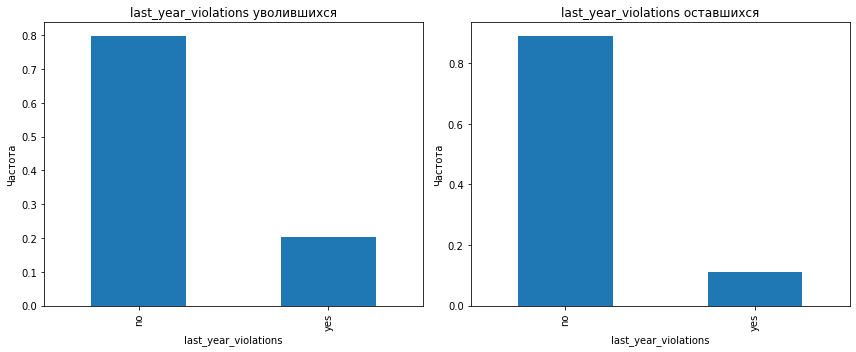

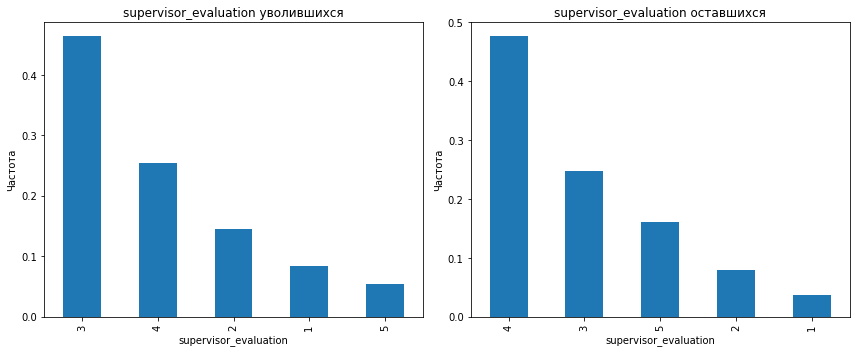

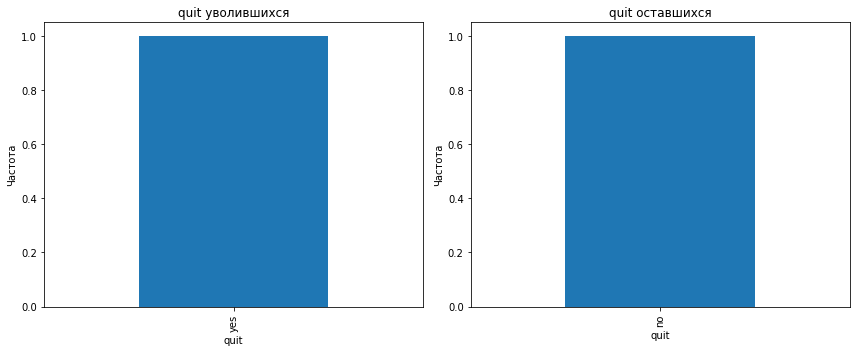

In [79]:
cat_bar_group_norm(quited, stayed, quit_cat)

Основная масса уволившихся сотрудников получала зарплату в диапазоне от 10 до 30 тысяч, что уступает зарплате у оставшихся, а также почти не работала больше трех лет. Почти все уволившиеся работали на позиции junior, а руководитель в основном оценивал их работу на 3 из 5. 

#### Проверим влияние удовлетворенности уровнем работы на то, уйдет ли сотрудник

In [80]:
df = test_features.merge(test_target_job).merge(test_target)

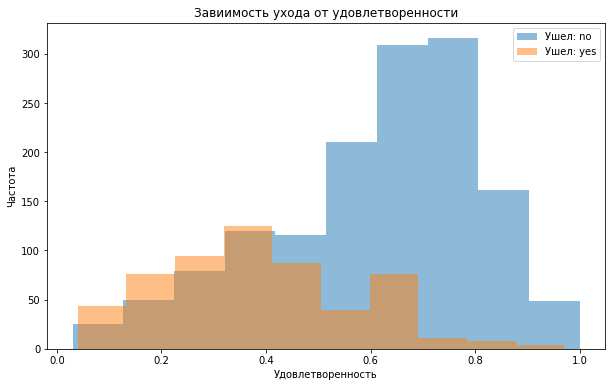

In [81]:
plt.figure(figsize=(10, 6))
for label in df['quit'].unique():
    subset = df[df['quit'] == label]
    plt.hist(subset['job_satisfaction_rate'], bins=10, alpha=0.5, label=f'Ушел: {label}')

plt.xlabel('Удовлетворенность')
plt.ylabel('Частота')
plt.title('Завиимость ухода от удовлетворенности')
plt.legend()
plt.show()

In [82]:
phik_matrix = df.phik_matrix(interval_cols=['job_satisfaction_rate'])

phik_value = phik_matrix.at['job_satisfaction_rate', 'quit']
print(f'Phi-корреляция: {phik_value}')

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 2000. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


Phi-корреляция: 0.6102629749056108


Проверим влияние тестом Манна-Уитни
Нулевая гипотеза: уровень удовлетворенности работой у работников, которые остались, такой же, как и у работников, которые ушли
Альтернативная гипотеза: уровни удовлетворенности отличаются

In [83]:
left_satisfaction = df[df['quit'] == 'yes']['job_satisfaction_rate']
stayed_satisfaction = df[df['quit'] == 'no']['job_satisfaction_rate']

u_stat, p_value = mannwhitneyu(left_satisfaction, stayed_satisfaction)

print(f'U-статистика: {u_stat}, p-значение: {p_value}')

U-статистика: 167292.5, p-значение: 5.673072286850858e-93


p-значение значительно меньше уровня значимости (0.05), значит мы отвергаем нулевую гипотезу. Уровни удовлетворенности отличаются

Действительно, удалось статистически подтвердить, что уйдет ли сотрудник, достаточно сильно зависит от его удовлетворенности работой, phi-кореляция - 0.61 

### Добавление нового входного признака

Предскажем удовлетворенность и добавим в данные

In [84]:
X_quit_train = quit_train.drop(['id', 'quit'], axis=1)
X_quit_train_transformed = data_preprocessor.transform(X_quit_train)

In [85]:
satisfaction_pred = tree.predict(X_quit_train_transformed)

In [86]:
quit_train['job_satisfaction_rate'] = satisfaction_pred

In [87]:
quit_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


### Подготовка данных

In [88]:
X_train = quit_train.drop(['quit', 'id', 'dept'], axis=1)
y_train = quit_train['quit']

In [89]:
num_col = X_train.select_dtypes(exclude='object').columns

In [90]:
ohe_col =  ['last_year_promo', 'last_year_violations']

In [91]:
ohe_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('imputer2', SimpleImputer(missing_values =' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

ord_pipe = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('imputer2', SimpleImputer(missing_values =' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle' ,'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [92]:
X_train_transformed = data_preprocessor.fit_transform(X_train)

#### Обучение модели

In [93]:
param_distributions = [
    {
        'model': [LogisticRegression(random_state=42)],
        'model__C': [0.01, 0.1, 1, 10], 
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    {
        'model': [DecisionTreeClassifier(random_state=42)],
        'model__max_depth': range(2, 12),
        'model__min_samples_split': range(2, 10),
        'model__min_samples_leaf': range(2, 8)
        
    },
    {
        'model': [SVC(probability=True)],
        'model__C': [ 1, 10,  8, 15, 100],  
        'model__kernel': ['linear', 'rbf'],
    }
]

In [94]:
pipe = Pipeline([
    ('model', LogisticRegression(random_state=42))
])


In [95]:
grid_search = GridSearchCV(
    pipe, 
    param_distributions,
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

In [96]:
%%time
grid_search.fit(X_train_transformed, y_train)

CPU times: user 1min 14s, sys: 330 ms, total: 1min 14s
Wall time: 1min 15s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(random_state=42)],
                          'model__C': [0.01, 0.1, 1, 10],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['liblinear']},
                         {'model': [DecisionTreeClassifier(random_state=42)],
                          'model__max_depth': range(2, 12),
                          'model__min_samples_leaf': range(2, 8),
                          'model__min_samples_split': range(2, 10)},
                         {'model': [SVC(probability=True)],
                          'model__C': [1, 10, 8, 15, 100],
                          'model__kernel': ['linear', 'rbf']}],
             scoring='roc_auc')

In [97]:
print(f'Параметр roc_auc у лучшей модели - {grid_search.best_score_}')

Параметр roc_auc у лучшей модели - 0.931196714457465


In [98]:
test_features['job_satisfaction_rate'] = y_pred

In [99]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.757254
1,686555,hr,junior,medium,1,no,no,4,30000,0.638153
2,467458,sales,middle,low,5,no,no,4,19200,0.553813
3,418655,sales,middle,low,6,no,no,4,19200,0.585589
4,789145,hr,middle,medium,5,no,no,5,40800,0.783444


In [100]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [101]:
test_target = test_features[['id']].merge(test_target)

In [102]:
X_test_transformed = data_preprocessor.transform(test_features.drop(['id', 'dept'], axis=1))

In [103]:
y_pred_proba = grid_search.predict_proba(X_test_transformed)

In [104]:
print(f"Метрика roc_auc на тестовой выборке - {roc_auc_score(test_target['quit'], y_pred_proba[:, 1])}")

Метрика roc_auc на тестовой выборке - 0.9058585955866374


### Выводы

In [105]:
grid_search.best_params_

{'model': SVC(probability=True), 'model__C': 10, 'model__kernel': 'rbf'}

Лучшая модель - модель опорных векторов с ядром rbf и параметром регуляризации C=10

# Общий вывод

Требовалось обучить две модели, которые бы предсказывали уровень удовлетворенности работой, а также уволится ли сотрудник.

Для этого были исправлены ошибки в данных, и они были подготовлены для обучения моделей.
На основе метрики SMAPE была выбрана модель дерева решений, которая предсказываает уровень удовлетворенности.
Подобные процессы были проделаны и с данными, имеющими информацию об уволившихся сотрудниках.
Была подобрана модель опорных векторов, которая показала наилучшую метрику ROC AUC, что показывает её "уверенность" в прогнозах

Можно сделать вывод, что увольняются чаще всего сотрудники на позиции junior, которые работали в фирме не более двух лет и не получали повышение. Возможно, причина может быть в том, что условия для позиции middle не устраивают сотрудников, либо же они вовсе не могут получить повышение, из-за чего становится легче уволиться